# Oil prices modelling with VAR and trading strategy

Basing myself on previous work, specially by *Kilian* such as:
1. *Kilian, Lutz* (2009) : **Not all oil price shocks are alike: Disentangling demand and supply shocks in the crude oil market**. *American Economic Review*, 99(3), 1053-69.
2. *Kilian, Lutz* (2019) : **Facts and Fiction in Oil Market Modeling**, CESifo
Working Paper, No. 7902, *Center for Economic Studies and ifo Institute (CESifo)*, Munich

>And quoting Kilian (2019) *"the relative importance of oil supply and oil demand shocks as drivers of the real price of oil is invariant to which admissible model solution one focuses on."*

As an excercise I am trying to model *Crude Oil Price* (or return) with a VAR model and some free data from **Nasdaq data link**.

At the end of the *VAR* model, I build a trading strategy based on a short stop-loss and the next day forecast. This strategy yields positive return in the testing data (*the whole pandemic years up to the Russian attack over Ukraine until 2022-06-02*) and in the backtest (*also a complicated era with the price jumping to 120 down afterwards to 20 USD*).
> For the sake of simplicity, it only trades at *Closing* prices

## About

I am Leonardo Brioschi, a Ph.D. Candidate in Accounting/Finance. Please visit https://leobrioschi.gitlab.io and contact me! 

In [327]:
import nasdaqdatalink as dlink
import numpy as np
import pandas as pd
from dotenv import dotenv_values #python-dotenv package
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error,explained_variance_score

In [93]:
''' Loading API Keys, please look at dotenv packages and issues with *environment variables* over notebooks to
understand this choice. 
    This will load the api key for NASDAQ DATA LINK on this session'''
config = dotenv_values(".env")
dlink.ApiConfig.api_key = config['NASDAQ_API_KEY']

In [94]:
opep_prices = dlink.get("OPEC/ORB")

In [95]:
country_list = ['USA', 'RUS', 'SAU', 'CAN', 'IRQ', 'CHN', 'IRN', 'ARE', 'BRA', 'KWT' , 'NOR', 'KAZ']

values_dfs = list()
notes_dfs = list()

for each in country_list:
    df = dlink.get(f'JODI/OIL_CRPRKD_{each}')
    df.columns = [ f'{each}_prod' , f'{each}_notes']
    values_dfs.append(df[[f'{each}_prod']])
    notes_dfs.append(df[[f'{each}_notes']])


productions = pd.concat(values_dfs, axis=1)
productions_notes = pd.concat(notes_dfs, axis=1)
#usa_prod = dlink.get("JODI/OIL_CRPRKD_USA")

In [117]:
productions.head()

USA_prod   RUS_prod  SAU_prod   CAN_prod  IRQ_prod   CHN_prod  \
Date                                                                         
2002-01-31  5847.5806  7001.0161    7150.0  1691.7006       0.0  3374.2839   
2002-02-28  5871.3571  7094.2500    7071.0  1768.0750       0.0  3338.7043   
2002-03-31  5883.4516  7143.4097    7096.0  1789.4413       0.0  3358.4632   
2002-04-30  5858.7000  7135.3200    7074.0  1822.0447       0.0  3341.5800   
2002-05-31  5923.7097  7214.6065    7031.0  1798.2426       0.0  3377.1174   

            IRN_prod  ARE_prod   BRA_prod  KWT_prod   NOR_prod  Total_prod  
Date                                                                        
2002-01-31    3310.0    1955.0  1445.9677    1750.0  3226.0155  36751.5644  
2002-02-28    3227.0    1941.0  1439.2500    1740.0  3282.2250  36772.8614  
2002-03-31    3222.0    1921.0  1460.9355    1742.0  2892.8313  36509.5326  
2002-04-30    3225.0    1769.0  1474.0333    1749.0  3284.1153  36732.7933  
2002-05-31    3230.0    1894.0  1486.0323    1748.0  3180.1090  36882.8175

Problem with **JODI** database is that Demand and Production is monthly. So we can't use it. I am proposing using **SPY** volumes as economic activity proxy. Since by **AP** theory, the *SDF* should bring all the economic information if the market has perfect information.

In [120]:
spy_volume = dlink.get(f'BATS/EDGX_SPY')
spy_volume.columns = ['spy_short_vol','spy_total_vol']
spy_volume.head()

spy_short_vol  spy_total_vol
Date                                    
2010-07-15      4784368.0      6204104.0
2010-07-16      5236262.0      6676552.0
2010-07-19      3982252.0      5158825.0
2010-07-20      5271658.0      7324495.0
2010-07-21      6057256.0      7735473.0

In [178]:
data = opep_prices.copy()
data.columns = ['oil_price']
data = data.join(spy_volume, how='inner')
data.describe()

oil_price  spy_short_vol  spy_total_vol
count  2990.000000   2.990000e+03   2.990000e+03
mean     74.587706   4.181131e+06   6.472844e+06
std      26.689714   2.497921e+06   3.725904e+06
min      12.220000   7.503550e+05   1.377953e+06
25%      52.312500   2.554572e+06   4.080632e+06
50%      70.480000   3.553246e+06   5.515680e+06
75%     104.047500   5.140745e+06   7.736823e+06
max     128.270000   2.805870e+07   3.743590e+07

In [122]:
data.tail()

oil_price  spy_short_vol  spy_total_vol
Date                                               
2022-05-26     116.50      2178953.0      3772016.0
2022-05-27     118.84      2465547.0      3978124.0
2022-05-31     122.94      3184439.0      4294431.0
2022-06-01     117.07      3141266.0      4786609.0
2022-06-02     114.62      2685100.0      3621822.0

I am also proposing using **FED's** bond rate to measure not only economic activity but early production shocks.

In [125]:
fed_rate = dlink.get(f'FED/RIFSPFF_N_D')
fed_rate.columns = ['fed_fund_rate']
fed_rate.tail()

fed_fund_rate
Date                     
2022-05-29           0.83
2022-05-30           0.83
2022-05-31           0.83
2022-06-01           0.83
2022-06-02           0.83

In [179]:
data = data.join(fed_rate, how='inner')
data.describe()

oil_price  spy_short_vol  spy_total_vol  fed_fund_rate
count  2990.000000   2.990000e+03   2.990000e+03    2990.000000
mean     74.587706   4.181131e+06   6.472844e+06       0.555659
std      26.689714   2.497921e+06   3.725904e+06       0.729747
min      12.220000   7.503550e+05   1.377953e+06       0.040000
25%      52.312500   2.554572e+06   4.080632e+06       0.090000
50%      70.480000   3.553246e+06   5.515680e+06       0.150000
75%     104.047500   5.140745e+06   7.736823e+06       0.910000
max     128.270000   2.805870e+07   3.743590e+07       2.450000

In [127]:
data.tail()

oil_price  spy_short_vol  spy_total_vol  fed_fund_rate
Date                                                              
2022-05-26     116.50      2178953.0      3772016.0           0.83
2022-05-27     118.84      2465547.0      3978124.0           0.83
2022-05-31     122.94      3184439.0      4294431.0           0.83
2022-06-01     117.07      3141266.0      4786609.0           0.83
2022-06-02     114.62      2685100.0      3621822.0           0.83

In [128]:
data.head()

oil_price  spy_short_vol  spy_total_vol  fed_fund_rate
Date                                                              
2010-07-15      73.26      4784368.0      6204104.0           0.19
2010-07-16      72.89      5236262.0      6676552.0           0.19
2010-07-19      72.94      3982252.0      5158825.0           0.19
2010-07-20      73.16      5271658.0      7324495.0           0.18
2010-07-21      73.16      6057256.0      7735473.0           0.18

In [180]:
data['oil_ret'] = data['oil_price'] / data['oil_price'].shift(1)
data['oil_ln_ret'] = data['oil_ret'].apply(np.log)
data['fed_fund_rate'] = data['fed_fund_rate'] / data['fed_fund_rate'].shift(1)
data['fed_fund_rate'] = data['fed_fund_rate'].apply(np.log)
data.dropna(axis=0,inplace=True)
data = data[['oil_price','oil_ln_ret','oil_ret','spy_short_vol','spy_total_vol','fed_fund_rate']]
data.head()

oil_price  oil_ln_ret   oil_ret  spy_short_vol  spy_total_vol  \
Date                                                                        
2010-07-16      72.89   -0.005063  0.994949      5236262.0      6676552.0   
2010-07-19      72.94    0.000686  1.000686      3982252.0      5158825.0   
2010-07-20      73.16    0.003012  1.003016      5271658.0      7324495.0   
2010-07-21      73.16    0.000000  1.000000      6057256.0      7735473.0   
2010-07-22      73.47    0.004228  1.004237      5859214.0      7894741.0   

            fed_fund_rate  
Date                       
2010-07-16       0.000000  
2010-07-19       0.000000  
2010-07-20      -0.054067  
2010-07-21       0.000000  
2010-07-22       0.000000

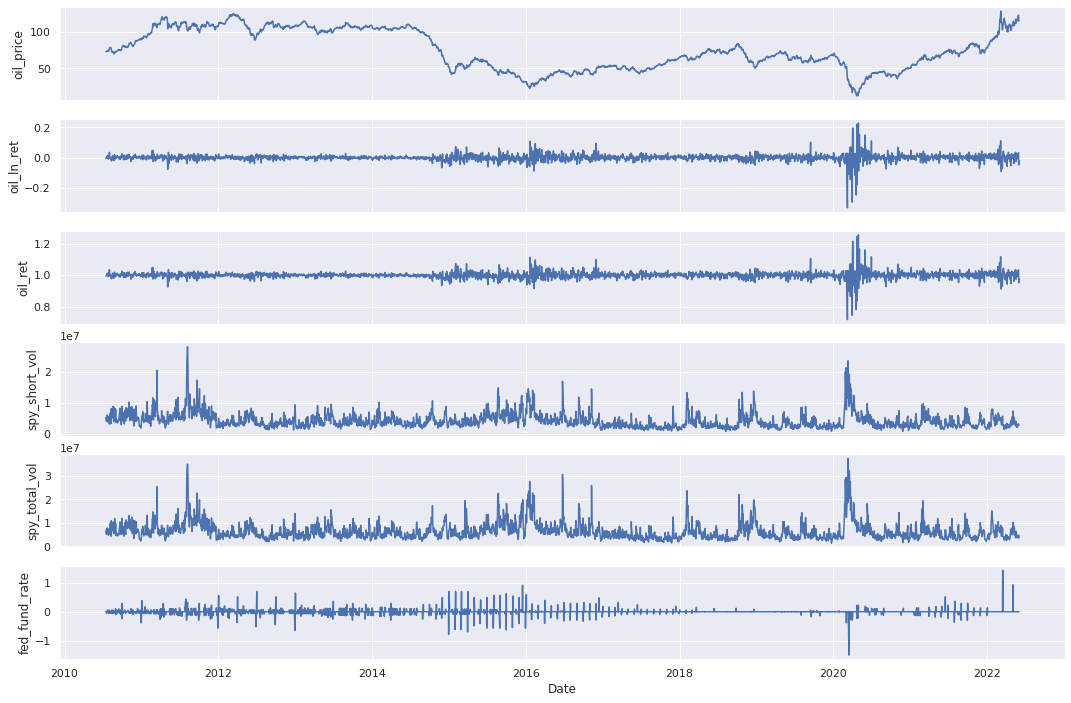

In [181]:
sns.set_theme(style="darkgrid")

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize=(18, 12), sharex=True)

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for col,ax in zip(data.columns,axs):
    sns.lineplot(data=data,y=col,x=data.index,ax=ax)



## Time-Series Modelling

There is a lot of increased volatility around **2020**, it seems a *VAR-GARCH* type would be more suited, but those (*such as BAKK-GARCH or DCC-GARCH*) are not available at **statsmodels** library and I haven't tested some codes found on *github* yet. Still, if we can at least survive the *"White noise test"* of the model's residuals we are golden and might get decent results, specially because the *SPY short volume* seems to pick up some of this increased volatility.

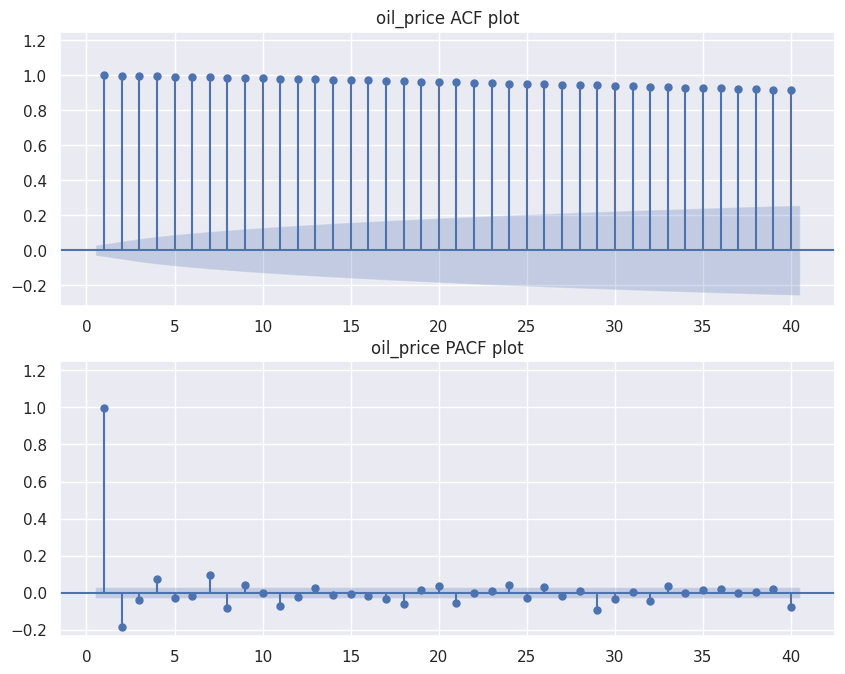

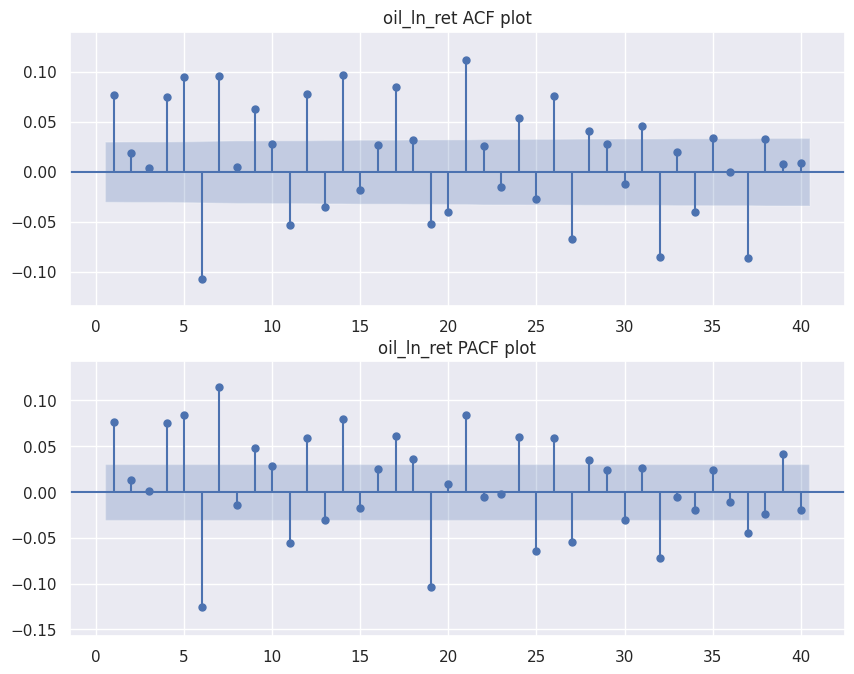

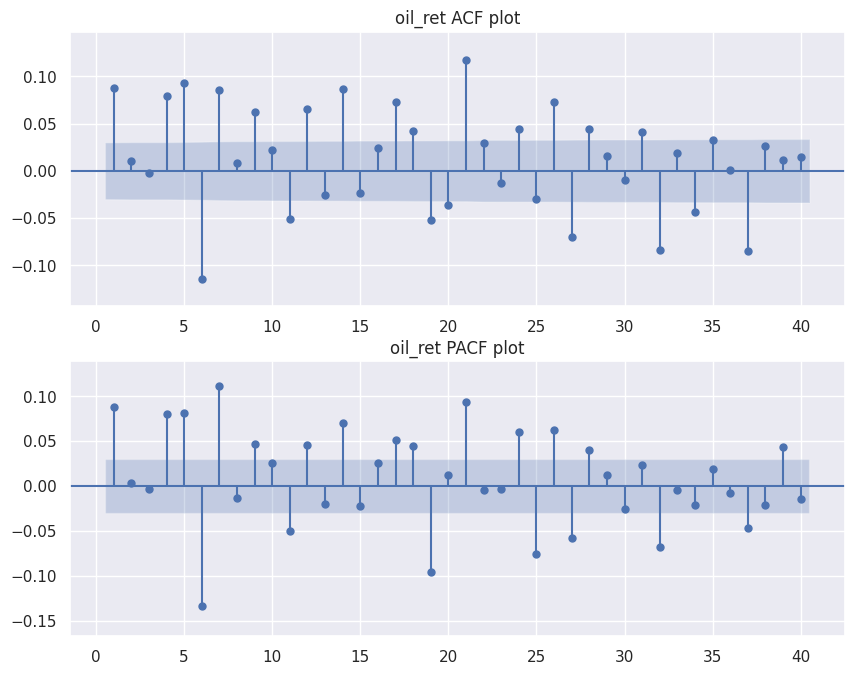

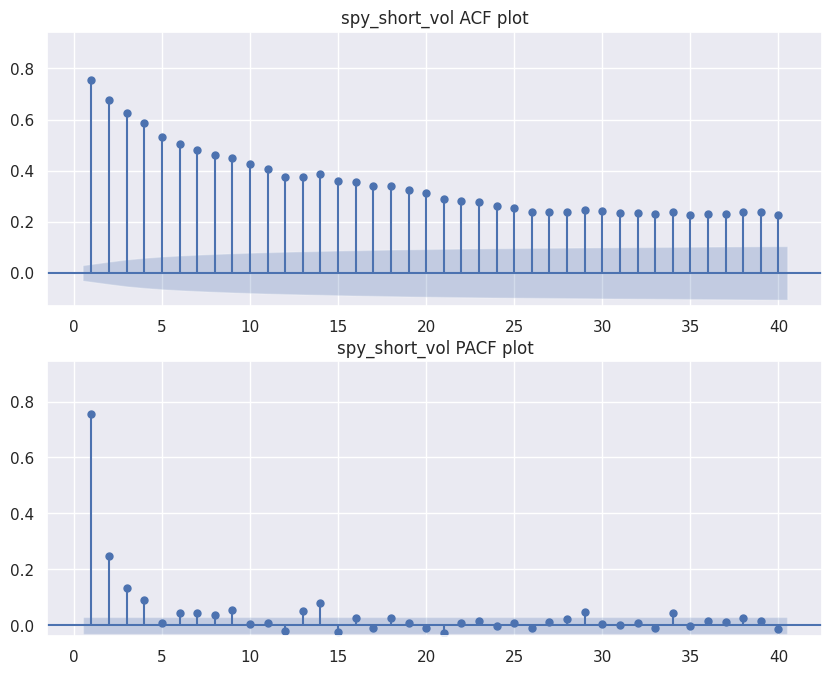

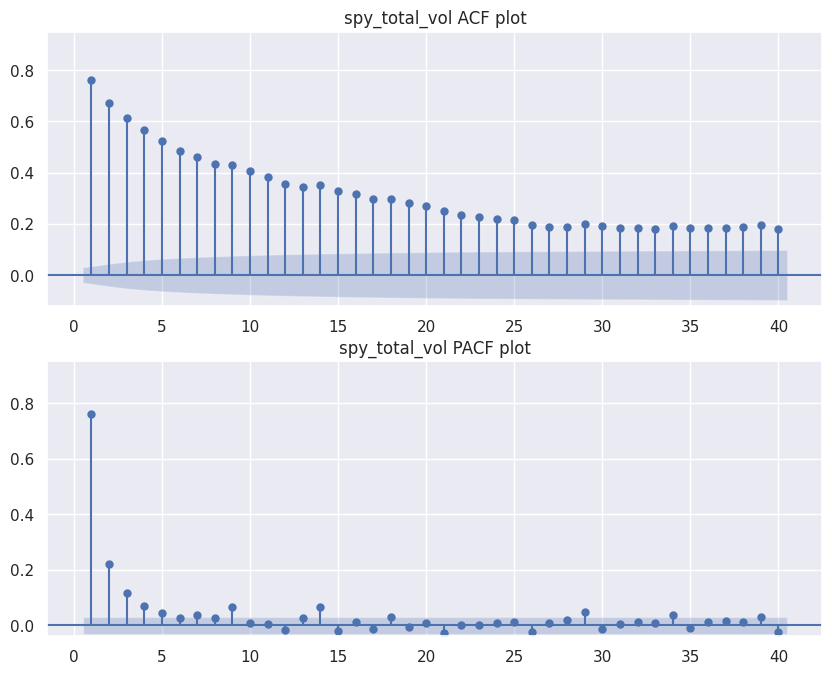

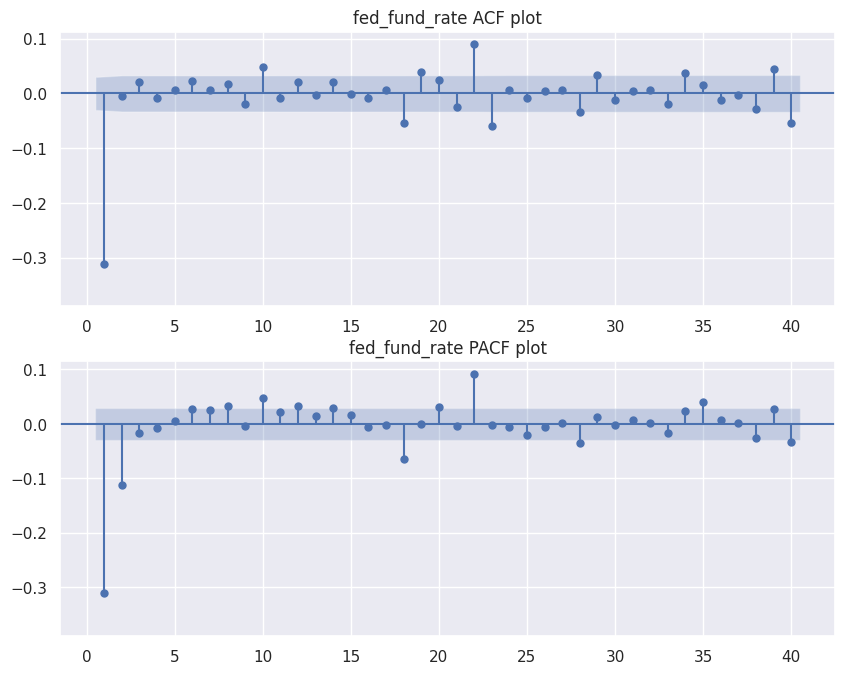

In [182]:
for each in data.columns.to_list():
    fig = plt.figure(figsize=(10, 8), dpi=100)
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data[each], lags=40, ax=ax1,zero=False,alpha=.10,auto_ylims=True)
    ax1.set_title(f'{each} ACF plot')
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data[each], lags=40, ax=ax2,method='yw',zero=False,alpha=.10,auto_ylims=True)
    ax2.set_title(f'{each} PACF plot')

Even on the natural log return of the **oil prices** the ACF/PACF plots are all around, a *GARCH* model with only the oil prices return might yield a better result! we will test it later. For now, I will test unit-root existance.

In [183]:
#Unit root tests
# Agumented Dickey-Fuller
results_adf = dict()
results_adf['adf-h0'] = 'Has Unit root'
results_adf['adf-key'] = {'stat':'calculate statistics',
    'pvalue':'calculated p-value',
    'lags':'lags selected through criterion',
    'obs':'num of observations',
    'critical values':{'1%':'critical value at 1%'
                        ,'5%':'critical value at 5%',
                        '10%':'critical value at 10%'}}
for each in data.columns.to_list():
    for structure in ['c','ct','ctt','n']:
        results_adf[f'adf-{each}-{structure}'] = tsa.stattools.adfuller(data[each],autolag='AIC',regression=structure,store=False)


In [195]:
''' Print only when ADF test is rejected: variable has no unit root '''
for key in results_adf:
    if len(results_adf[key]) == 6:
        if results_adf[key][1] < 0.1: print(f'{key} has a pvalue of {results_adf[key][1]}')

adf-oil_ln_ret-c has a pvalue of 3.825399866842211e-13
adf-oil_ln_ret-ct has a pvalue of 1.2986776502349014e-11
adf-oil_ln_ret-ctt has a pvalue of 3.015326216963006e-11
adf-oil_ln_ret-n has a pvalue of 6.530325588666657e-14
adf-oil_ret-c has a pvalue of 1.15851936257347e-13
adf-oil_ret-ct has a pvalue of 4.091593675527105e-12
adf-oil_ret-ctt has a pvalue of 8.028198467207695e-12
adf-spy_short_vol-c has a pvalue of 9.957953739884102e-10
adf-spy_short_vol-ct has a pvalue of 3.2251654903528706e-09
adf-spy_short_vol-ctt has a pvalue of 1.1575959455904218e-08
adf-spy_short_vol-n has a pvalue of 0.01813190597978429
adf-spy_total_vol-c has a pvalue of 3.341723893948659e-11
adf-spy_total_vol-ct has a pvalue of 4.1090490687218965e-10
adf-spy_total_vol-ctt has a pvalue of 2.0727870206970823e-09
adf-spy_total_vol-n has a pvalue of 0.01932901449389871
adf-fed_fund_rate-c has a pvalue of 5.992317113264962e-17
adf-fed_fund_rate-ct has a pvalue of 5.9352384040972545e-15
adf-fed_fund_rate-ctt has a pv

In [190]:
# KPSS test
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    results_kpss = dict()
    results_kpss['kpss-key'] = {'kpss_stat':'calculated statistic',
                            'p-value':'calculated p-value',
                            'lags':'lags selected calculated using the data-dependent method of Hobijn et al. (1998)',
                            'critical values':{'1%':'critical value at 1%'
                                ,'5%':'critical value at 5%',
                                '10%':'critical value at 10%'}
                            }
    for each in data.columns.to_list():
        for structure in ['c','ct']:
            results_kpss[f'kpss-{each}-{structure}'] = tsa.stattools.kpss(data[each],regression=structure,store=False)

In [216]:
''' Print only when ADF test is rejected: variable has no unit root '''
for key in results_kpss:
    if len(results_kpss[key]) == 4 and key != 'kpss-key':
        if float(list(results_kpss[key])[1]) > 0.01: print(f'{key} has a pvalue of {results_kpss[key][1]}')

kpss-oil_ln_ret-c has a pvalue of 0.1
kpss-oil_ln_ret-ct has a pvalue of 0.1
kpss-oil_ret-c has a pvalue of 0.1
kpss-oil_ret-ct has a pvalue of 0.1
kpss-spy_short_vol-ct has a pvalue of 0.042240192543632094
kpss-spy_total_vol-c has a pvalue of 0.061556451794907534
kpss-spy_total_vol-ct has a pvalue of 0.1
kpss-fed_fund_rate-c has a pvalue of 0.1
kpss-fed_fund_rate-ct has a pvalue of 0.1


Now I will set up training and testing data.

In [218]:
''' setting up test and training databases '''
training = round(0.8 * len(data))
train = data.iloc[0:training]
test = data.iloc[training:]

print(f'Original data shape: {data.shape}')
print(f'The shape of the training data: {train.shape}')
print(f'The shape of testing data: {test.shape}. Validation check: {data.shape[0] == train.shape[0] + test.shape[0]}')


Original data shape: (2989, 6)
The shape of the training data: (2391, 6)
The shape of testing data: (598, 6). Validation check: True


In [226]:
''' VAR model '''
vars_order = ['fed_fund_rate','spy_short_vol','oil_ln_ret']
var_data = train[vars_order]
maxlag = 60

#using AIC because BIC is overly parsimonious, more at Kilian, Lutkepohl's book
model = tsa.VAR(var_data)
results = model.fit(maxlags=maxlag, ic='aic') 


/home/leo/phd/joaozinho/project_venv/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [227]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Jun, 2022
Time:                     02:06:25
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    15.3268
Nobs:                     2387.00    HQIC:                   15.2668
Log likelihood:          -28301.9    FPE:                4.12443e+06
AIC:                      15.2324    Det(Omega_mle):     4.05777e+06
--------------------------------------------------------------------
Results for equation fed_fund_rate
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.002763         0.004015           -0.688           0.491
L1.fed_fund_rate        -0.499770         0.020491          -24.390           0.000
L1.spy_short_vol         0.000000       

From the results summary, using the **Akaike criterium**, we have a VAR with 4 lags, not only that, but the fourth lag of **SPY short volume** is statistically significant towards **ln(Oil prices return)**. 

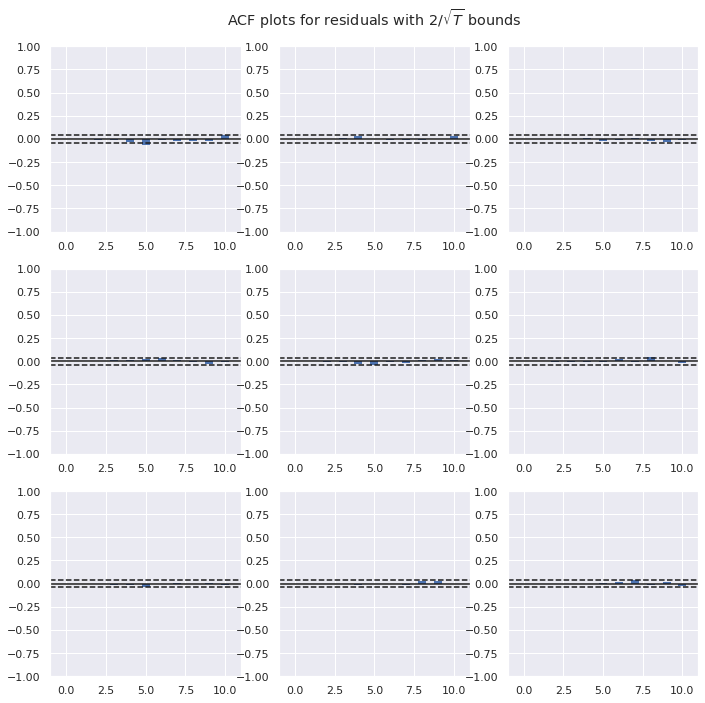

In [376]:
results.plot_acorr();

Looking at the residuals' ACF plots we should pass the whitness test.

In [239]:
normality = results.test_normality(signif=0.01);
print(normality)

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 1% significance level. Test statistic: 65701.188, critical value: 16.812>, p-value: 0.000>


In [246]:
whiteness = results.test_whiteness(nlags=16,signif=0.01);
print(whiteness)

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 16 is zero: reject at 1% significance level. Test statistic: 170.134, critical value: 145.099>, p-value: 0.000>


As expected, the residuals are not normal, but pass the whiteness test at 1%. Since it's p-value is 0%, it be rejected at any significance level.

In [317]:
''' Creating the forecast base, since the std. deviation of the error just shoots up 
    without new information anything beyond 1 setp-ahead forecast is complicated and uncalled for '''
lag_order = results.k_ar
forecast_base = train[vars_order].iloc[-lag_order:]
forecast_base.head()

fed_fund_rate  spy_short_vol  oil_ln_ret
Date                                                
2020-01-14       0.000000      2038632.0   -0.006682
2020-01-15       0.000000      2596082.0   -0.004735
2020-01-16       0.000000      2000650.0    0.004582
2020-01-17       0.006473      2907645.0   -0.000610

In [318]:
''' Completing the forecast base with the test values
    Also, creating the forecast 0 dataframe '''
forecast_base = pd.concat([forecast_base,test[vars_order]])
forecast = test[vars_order].copy(deep=True)
forecast.loc[:,:] = 0
new_forecast_cols = [f'{x}_lb' for x in forecast_base.columns.to_list()] + [f'{x}_ub' for x in forecast_base.columns.to_list()]
forecast[new_forecast_cols] = 0
forecast.head()

fed_fund_rate  spy_short_vol  oil_ln_ret  fed_fund_rate_lb  \
Date                                                                     
2020-01-21            0.0            0.0         0.0                 0   
2020-01-22            0.0            0.0         0.0                 0   
2020-01-23            0.0            0.0         0.0                 0   
2020-01-24            0.0            0.0         0.0                 0   
2020-01-27            0.0            0.0         0.0                 0   

            spy_short_vol_lb  oil_ln_ret_lb  fed_fund_rate_ub  \
Date                                                            
2020-01-21                 0              0                 0   
2020-01-22                 0              0                 0   
2020-01-23                 0              0                 0   
2020-01-24                 0              0                 0   
2020-01-27                 0              0                 0   

            spy_short_vol_ub  oil_ln_ret_ub  
Date                                         
2020-01-21                 0              0  
2020-01-22                 0              0  
2020-01-23                 0              0  
2020-01-24                 0              0  
2020-01-27                 0              0

In [319]:
''' Creating the forecast it uses the last 4 lags available (even from test, on a previous day) to make an one-step-ahead
    forecast for the whole testing subject '''
for time in range(0,len(test)):
    fcast = results.forecast_interval(forecast_base[vars_order].iloc[time:lag_order+time].values,1)
    fcast = np.reshape(fcast,-1)
    forecast.iloc[time] = fcast
    

In [320]:
forecast.tail()

fed_fund_rate  spy_short_vol  oil_ln_ret  fed_fund_rate_lb  \
Date                                                                     
2022-05-26      -0.000683   2.661907e+06    0.004892         -0.169719   
2022-05-27       0.001744   2.576112e+06    0.001876         -0.167292   
2022-05-31      -0.003824   2.513244e+06    0.004036         -0.172860   
2022-06-01       0.000217   2.827925e+06    0.006707         -0.168819   
2022-06-02       0.008267   3.536561e+06   -0.014385         -0.160769   

            spy_short_vol_lb  oil_ln_ret_lb  fed_fund_rate_ub  \
Date                                                            
2022-05-26    -389633.582624      -0.024860          0.168353   
2022-05-27    -475427.793911      -0.027875          0.170780   
2022-05-31    -538296.658530      -0.025716          0.165212   
2022-06-01    -223615.322294      -0.023045          0.169253   
2022-06-02     485020.813998      -0.044137          0.177303   

            spy_short_vol_ub  oil_ln_ret_ub  
Date                                         
2022-05-26      5.713447e+06       0.034644  
2022-05-27      5.627653e+06       0.031628  
2022-05-31      5.564784e+06       0.033788  
2022-06-01      5.879465e+06       0.036459  
2022-06-02      6.588101e+06       0.015367

In [316]:
test[vars_order].tail()

fed_fund_rate  spy_short_vol  oil_ln_ret
Date                                                
2022-05-26            0.0      2178953.0    0.005768
2022-05-27            0.0      2465547.0    0.019887
2022-05-31            0.0      3184439.0    0.033918
2022-06-01            0.0      3141266.0   -0.048924
2022-06-02            0.0      2685100.0   -0.021150

In [331]:
mse = mean_squared_error(test['oil_ln_ret'], forecast['oil_ln_ret'])
print(f'The measured Mean Squared Error is: {mse}')

The measured Mean Squared Error is: 0.001681176596311343


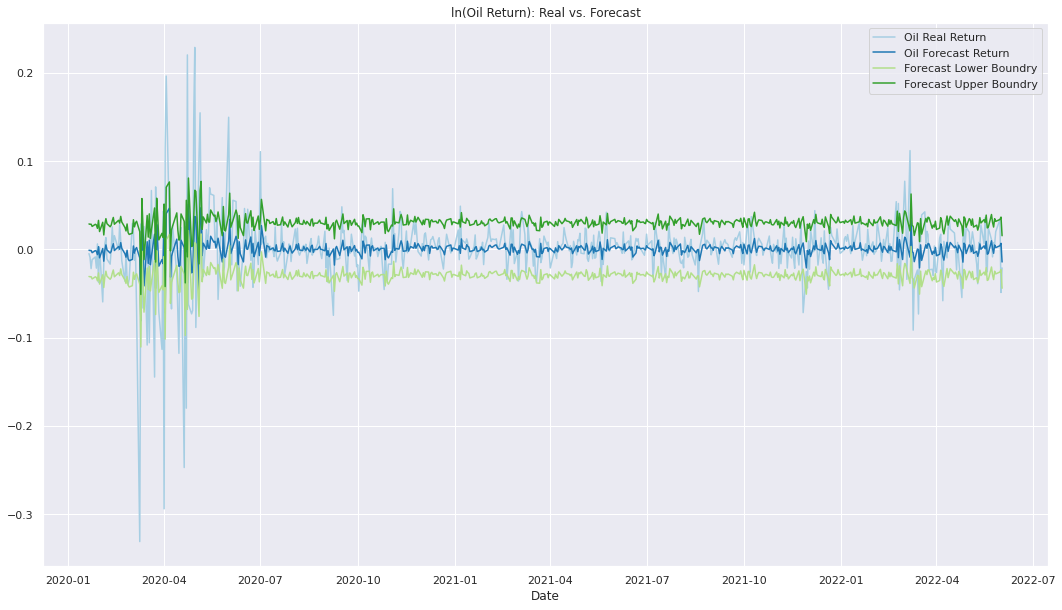

In [375]:
''' Plotting the forecast (1-step-ahead) versus real life. '''
plot_forecast = test['oil_ln_ret'].copy(deep=True)
plot_forecast = pd.concat([plot_forecast,forecast[[each for each in forecast.columns if 'oil' in each]]],axis=1)
plot_forecast.columns = ['Oil Real Return','Oil Forecast Return', 'Forecast Lower Boundry', 'Forecast Upper Boundry']

fig, (ax1) = plt.subplots(1, figsize=(18, 10), sharex=True)
ax1.set_title('ln(Oil Return): Real vs. Forecast')
sns.lineplot(data=plot_forecast, ax=ax1, palette='Paired', dashes=False);


It basically seems, from the **Mean Squared Error**(*0.00168*) and the graph that the model 'kinda' predicts the sign, but not the value, which is expected since we are treating an heteroskedastic error as homoskedastic. The model still lacks another vector that could bring more information about the Oil's variance structure (another way of solving it).
**Remember:** The model is only using two additional structures to model the crude oil's return: 
1. Fed fund rate;
2. SPY short volatility.

There is something else very important, **during the test period, we have the COVID's pandemic unravelling, and the Russian attack over Ukraine.** Almost two years apart (*2020-04 and 2022-04*), they certainly indicates the worst time for our model.

In [378]:
irf = results.irf(lag_order*10)

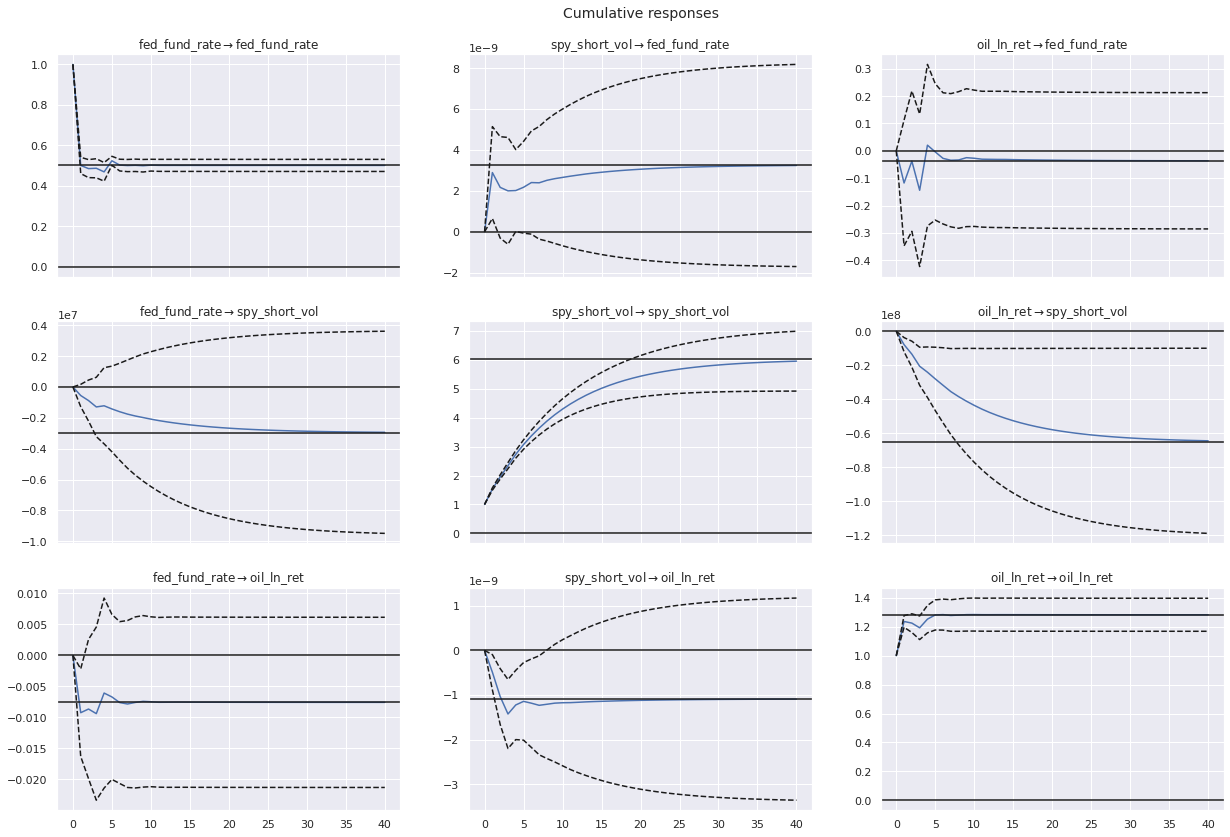

In [383]:
fig = irf.plot_cum_effects();
fig.set_size_inches(18,12)

From the cumulative impulse responses seeems a lot of **SPY's** variation and **fed's** passes to the oil prices in 2 days but it normalizes after 5.

## Is a trading strategy feasible?

So far, our modelling (constrained by the free data gathered from nasdaq data link) sort of hits the swings but not the prices, looking at our **forecast graph**, it seems at least the standard error boundries (albeit calculated without accounting for heteroskedasticity) works a bit like *bollinger bands*.

**Thus, can we use our model as a trading strategy?**

The first idea that comes to mind buying when the next-day forecast is positive, we could buy it at closing price, and sell it when the next day forecast is negative (also selling at the closing price). Also a stop-loss of 0.5% is up. 

These assumptions (of the buying and selling prices) are here just to make calculations easier, of course trading at exacly these prices at the end of the day sometimes is not feasible.

In [510]:
''' Creating a DataFrame for keeping track of the strategy ''' 
strategy = plot_forecast.copy(deep=True)
strategy['position'] = 0


In [511]:
''' Creating the sell signal '''
in_position = 0
for day in range(0,len(strategy)-1):
    if strategy['Oil Real Return'].iloc[day] < 0 and strategy['Oil Forecast Return'].iloc[day+1] > 0 and in_position == 0:
        strategy.iloc[day,4] = -1
        in_position = 1
    elif in_position == 1 and strategy['Oil Forecast Return'].iloc[day+1] < 0:
        strategy.iloc[day,4] = 1
        in_position = 0


In [809]:
''' Creating a DataFrame for keeping track of the strategy ''' 
strategy = plot_forecast.copy(deep=True)
strategy['position'] = 0

''' bringing the original prices to calculate our return '''
strategy = strategy.join(data[['oil_price']], how='left')

''' Creating the trading signal '''
in_position = 0
last_order = 0
stop_loss = 0.005
for day in range(0,len(strategy)-1):
    if strategy['Oil Real Return'].iloc[day] < 0.05 and strategy['Oil Forecast Return'].iloc[day+1] > 0.0 and in_position == 0 and strategy['Oil Real Return'].iloc[day-1] > 0 and strategy['Oil Real Return'].iloc[day-2] > 0:
        strategy.iloc[day,4] = -1
        in_position = 1
        last_order = strategy['oil_price'].iloc[day]
    elif in_position == 1 and (strategy['Oil Forecast Return'].iloc[day+1] < 0.0 or (strategy['oil_price'].iloc[day]/last_order - 1) < - stop_loss):
        strategy.iloc[day,4] = 1
        in_position = 0
        last_order = 0

In [814]:
pd.set_option("display.max_rows", 150, "display.max_columns", None)
strategy.head(5)

Oil Real Return  Oil Forecast Return  Forecast Lower Boundry  \
Date                                                                       
2020-01-21        -0.004891            -0.001058               -0.030810   
2020-01-22        -0.009237            -0.001422               -0.031174   
2020-01-23        -0.021890            -0.001307               -0.031059   
2020-01-24        -0.011767            -0.003835               -0.033587   
2020-01-27        -0.008675            -0.001460               -0.031211   

            Forecast Upper Boundry  position  oil_price  gains  
Date                                                            
2020-01-21                0.028694         0      65.26    0.0  
2020-01-22                0.028330         0      64.66    0.0  
2020-01-23                0.028445         0      63.26    0.0  
2020-01-24                0.025917         0      62.52    0.0  
2020-01-27                0.028292         0      61.98    0.0

In [815]:
''' number of times we are buying, so we are only buying it 46 times in almost two years '''
strategy.loc[strategy['position'] == -1,['position']].count()

position    46
dtype: int64

In [810]:
''' Calculating the costs and gains '''
strategy['gains'] = strategy['position'] * strategy['oil_price']
strategy['gains'].sum()

15.29000000000007

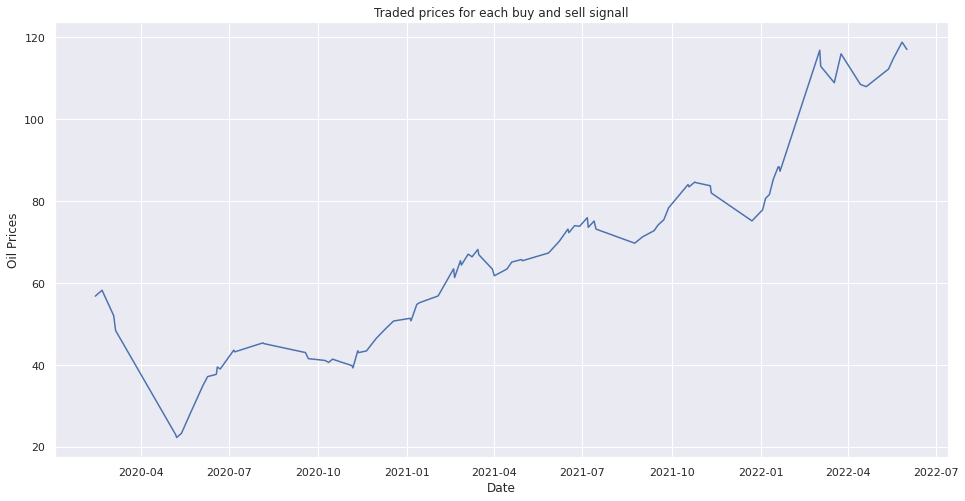

In [816]:
''' Plotting the prices where trading was done '''
movements = strategy.loc[strategy['gains'] != 0, ['gains']]
movements['absolute'] = movements['gains'].apply(abs)

fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharex=True)
ax1.set_title('Traded prices for each buy and sell signall')
ax1.set_ylabel('Oil Prices')
sns.lineplot(data=movements , y='absolute', x=movements.index, ax=ax1, palette='Paired');

In [817]:
sell = movements.loc[movements['gains'] > 0,['gains']]
sell.columns = ['sell_price']
sell['sell_dates'] = sell.index
buy  = movements.loc[movements['gains'] < 0,['gains']]
buy.columns = ['buy_price']
buy['buy_dates'] = buy.index

In [818]:
''' Creating the list of the trades: Buy and Sell '''
trade_pairs = pd.concat([buy.reset_index(),sell.reset_index()], ignore_index=False,axis=1)
trade_pairs.drop(columns=['Date'],inplace=True)
trade_pairs['return'] = trade_pairs['sell_price'] + trade_pairs['buy_price']
trade_pairs.head()

buy_price  buy_dates  sell_price sell_dates  return
0     -56.77 2020-02-14       58.21 2020-02-21    1.44
1     -52.01 2020-03-04       48.35 2020-03-06   -3.66
2     -22.91 2020-05-07       22.21 2020-05-08   -0.70
3     -23.25 2020-05-13       28.06 2020-05-22    4.81
4     -34.85 2020-06-04       37.10 2020-06-09    2.25

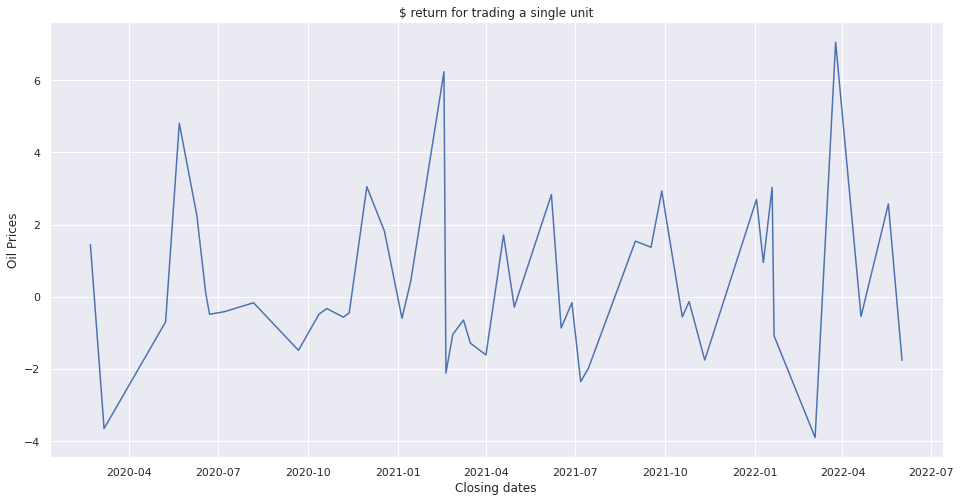

In [819]:
''' Plotting the absolute return of each trade '''

fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharex=True)
ax1.set_title('$ return for trading a single unit')
ax1.set_ylabel('Oil Prices')
ax1.set_xlabel('Closing dates')
sns.lineplot(data=trade_pairs , y='return', x='sell_dates', ax=ax1, palette='Paired');

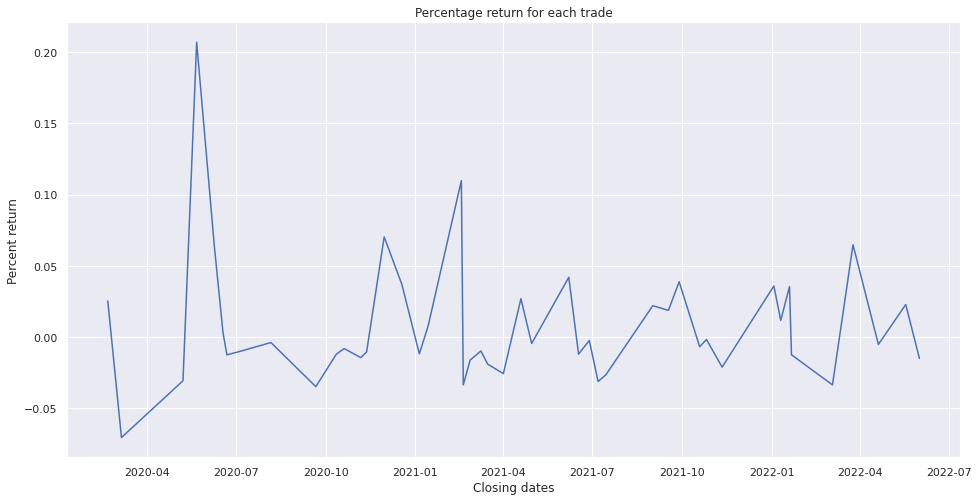

In [820]:
''' Creating the percentage return, and plotting it '''
trade_pairs['return_pct'] = trade_pairs['return'] / (-1 * trade_pairs['buy_price'])

fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharex=True)
ax1.set_title('Percentage return for each trade')
ax1.set_ylabel('Percent return')
ax1.set_xlabel('Closing dates')
sns.lineplot(data=trade_pairs , y='return_pct', x='sell_dates', ax=ax1, palette='Paired');

The percentage return seems to be higher only during the beggining of the pandemic, although the biggest downside is also during the same period. There is also a period of negative returns at the start of the Russian attack over Ukraine.

In [821]:
''' Calculating total percent return '''
total_pct_return = 1

for trade in trade_pairs['return_pct']:
    if trade >= 0:
        total_pct_return = total_pct_return * (1 + trade) #capitalize
    else:
        total_pct_return = total_pct_return / (1 + (-1* trade)) #discount

total_pct_return = total_pct_return-1
print(f'The total percentage return is {total_pct_return}')

The total percentage return is 0.3817716978342507


In [822]:
''' Seems the return is a bit high, let's find out why '''
trade_pairs.describe(include='all', datetime_is_numeric=True)

buy_price                      buy_dates  sell_price  \
count   46.000000                             46   46.000000   
mean   -65.368261  2021-04-08 06:15:39.130434816   65.700652   
min   -118.840000            2020-02-14 00:00:00   22.210000   
25%    -75.815000            2020-10-21 00:00:00   45.485000   
50%    -65.565000            2021-03-22 12:00:00   65.260000   
75%    -44.012500            2021-10-11 18:00:00   78.242500   
max    -22.910000            2022-05-27 00:00:00  117.070000   
std     23.735641                            NaN   23.739293   

                          sell_dates     return  return_pct  
count                             46  46.000000   46.000000  
mean   2021-04-12 04:10:26.086956544   0.332391    0.007657  
min              2020-02-21 00:00:00  -3.910000   -0.070371  
25%              2020-10-24 06:00:00  -1.005000   -0.014752  
50%              2021-03-24 00:00:00  -0.375000   -0.005866  
75%              2021-10-13 18:00:00   1.667500    0.024747  
max              2022-06-01 00:00:00   7.060000    0.206882  
std                              NaN   2.291654    0.044710

In [824]:
''' 20% of return seems out of this world, finding out which trades gives us higher returns '''
trade_pairs.loc[trade_pairs['return_pct'] > 0.10 ]

buy_price  buy_dates  sell_price sell_dates  return  return_pct
3      -23.25 2020-05-13       28.06 2020-05-22    4.81    0.206882
18     -56.82 2021-02-02       63.06 2021-02-17    6.24    0.109820

In [826]:
''' Now finding out which trades gives us the worst for our strategy '''
trade_pairs.loc[trade_pairs['return_pct'] < -0.05 ]

buy_price  buy_dates  sell_price sell_dates  return  return_pct
1     -52.01 2020-03-04       48.35 2020-03-06   -3.66   -0.070371

In [827]:
''' Seems our biggest gains and losses were due to the pandemic, but anyway, all the testing data was special.
    We've got to go through few waves of COVID-19 and then one of the biggest Oil Producers attacked Ukraine. 
    How would our strategy fare without those big wins and losses?'''

super_highs_lows = trade_pairs.loc[(trade_pairs['return_pct'] > 0.10) |  (trade_pairs['return_pct'] < -0.05) ,'return_pct']

new_pct_return = total_pct_return + 1

for trade in super_highs_lows:
    if trade <= 0:
        new_pct_return = new_pct_return * (1 + (-1*trade)) #capitalize
    else:
        new_pct_return = new_pct_return / (1 + (trade)) #discount

new_pct_return = new_pct_return - 1
print(f'The total percentage return, without the pandemic gains is {new_pct_return}')

The total percentage return, without the pandemic gains is 0.10421391077009945


In [828]:
time_frame = trade_pairs['sell_dates'] - trade_pairs['buy_dates']
print(f'The sum of days in a position is {time_frame.sum()}')
time_frame.describe()

The sum of days in a position is 180 days 00:00:00


count                           46
mean     3 days 21:54:46.956521739
std      3 days 09:23:59.730797868
min                1 days 00:00:00
25%                1 days 00:00:00
50%                3 days 00:00:00
75%                5 days 00:00:00
max               15 days 00:00:00
dtype: object

### Strategy Return

The strategy has paid off. It had wins and losses, but **in two years, it achieved an astonishing 38% return.** The biggest returns and losses were during the very begginig of the pandemic, *even discounting those, the return is 10.4%.*

Mind you, over these two years **only 46 trades** were done, totaling **180 days in a position.** Even in a country with high interest rates but somewhat *"safe"* (like *Brazil*) 17.2% of return is a good measure.

## Backtesting

In [584]:
''' Creating the base for the backtest DataFrame '''
backtest_base = train.copy(deep=True)
backtest_base.drop(columns=['spy_total_vol','oil_ret'], inplace=True)
backtest_base.head()

oil_price  oil_ln_ret  spy_short_vol  fed_fund_rate
Date                                                           
2010-07-16      72.89   -0.005063      5236262.0       0.000000
2010-07-19      72.94    0.000686      3982252.0       0.000000
2010-07-20      73.16    0.003012      5271658.0      -0.054067
2010-07-21      73.16    0.000000      6057256.0       0.000000
2010-07-22      73.47    0.004228      5859214.0       0.000000

In [593]:
backtest_base.iloc[0:4,-3:]

oil_ln_ret  spy_short_vol  fed_fund_rate
Date                                                
2010-07-16   -0.005063      5236262.0       0.000000
2010-07-19    0.000686      3982252.0       0.000000
2010-07-20    0.003012      5271658.0      -0.054067
2010-07-21    0.000000      6057256.0       0.000000

In [603]:
''' Creating the dataframe that will hold the backtest results '''
backtest = backtest_base.iloc[4:,-3:].copy(deep=True)
backtest.loc[:,:] = 0
new_backtest_cols = [f'{x}_lb' for x in backtest.columns.to_list()] + [f'{x}_ub' for x in backtest.columns.to_list()]
backtest[new_backtest_cols] = 0
backtest.head(1)

oil_ln_ret  spy_short_vol  fed_fund_rate  oil_ln_ret_lb  \
Date                                                                  
2010-07-22         0.0            0.0            0.0              0   

            spy_short_vol_lb  fed_fund_rate_lb  oil_ln_ret_ub  \
Date                                                            
2010-07-22                 0                 0              0   

            spy_short_vol_ub  fed_fund_rate_ub  
Date                                            
2010-07-22                 0                 0

In [604]:
''' Creating the backtest it uses the last 4 lags available (from backtest_base) to make an one-step-ahead
    forecast for the whole testing subject '''
for time in range(4,len(backtest_base)):
    fcast = results.forecast_interval(backtest_base[vars_order].iloc[time-4:time].values,1)
    fcast = np.reshape(fcast,-1)
    backtest.iloc[time-4] = fcast

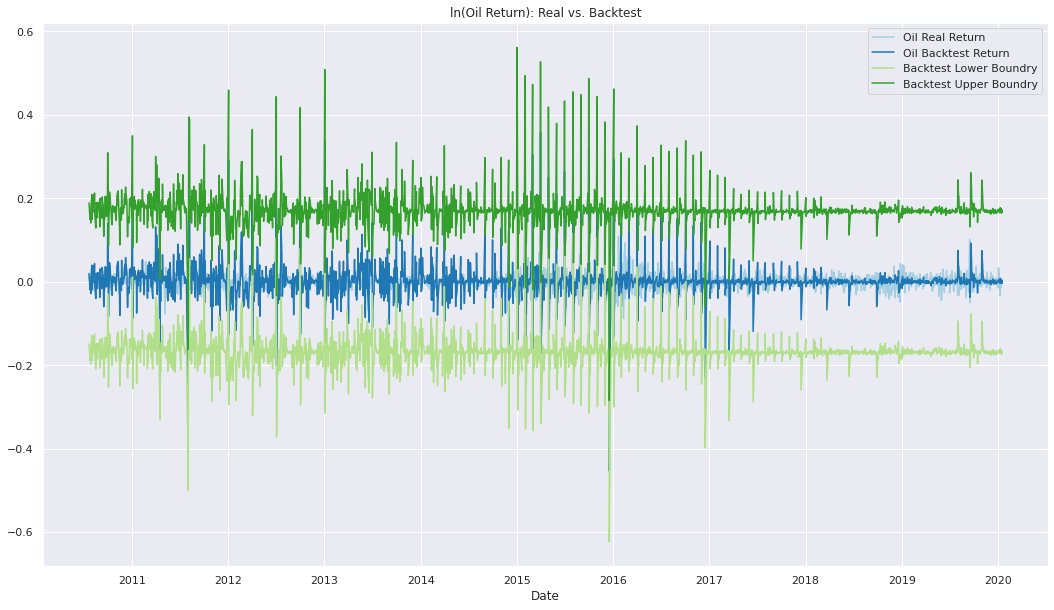

In [608]:
''' Plotting the backtest (1-step-ahead) versus real life. '''
plot_backtest = backtest_base['oil_ln_ret'].iloc[4:].copy(deep=True)
plot_backtest = pd.concat([plot_backtest,backtest[[each for each in backtest.columns if 'oil' in each]]],axis=1)
plot_backtest.columns = ['Oil Real Return','Oil Backtest Return', 'Backtest Lower Boundry', 'Backtest Upper Boundry']

fig, (ax1) = plt.subplots(1, figsize=(18, 10), sharex=True)
ax1.set_title('ln(Oil Return): Real vs. Backtest')
sns.lineplot(data=plot_backtest, ax=ax1, palette='Paired', dashes=False);

In general the stability is much better. The next steps are:
1. Measure the MSE;
2. Generating trading signals with the backtest data.

In [609]:
mse_back = mean_squared_error(backtest_base['oil_ln_ret'].iloc[4:], backtest['oil_ln_ret'])
print(f'The measured Mean Squared Error is: {mse_back}. The testing MSE was {mse}')

The measured Mean Squared Error is: 0.002142718302184101. The testing MSE was 0.001681176596311343


In [811]:
''' Creating a DataFrame for keeping track of the strategy on the backtest ''' 
strategy_back = plot_backtest.copy(deep=True)
strategy_back['position'] = 0

''' bringing the original prices to calculate our return '''
strategy_back = strategy_back.join(data[['oil_price']], how='left')

''' Creating the trading signal '''
in_position = 0
last_order = 0
stop_loss = 0.005
for day in range(0,len(strategy_back)-1):
    if strategy_back['Oil Real Return'].iloc[day] < 0.05 and strategy_back['Oil Backtest Return'].iloc[day+1] > 0.0 and in_position == 0 and strategy_back['Oil Real Return'].iloc[day-1] > 0 and strategy_back['Oil Real Return'].iloc[day-2] > 0:
        strategy_back.iloc[day,4] = -1
        in_position = 1
        last_order = strategy_back['oil_price'].iloc[day]
    elif in_position == 1 and (strategy_back['Oil Backtest Return'].iloc[day+1] < 0.0 or (strategy_back['oil_price'].iloc[day]/last_order - 1) < - stop_loss):
        strategy_back.iloc[day,4] = 1
        in_position = 0
        last_order = 0

In [812]:
#''' bringing the original prices to calculate our return '''
#strategy_back = strategy_back.join(data[['oil_price']], how='left')

''' Calculating the costs and gains '''
strategy_back['gains'] = strategy_back['position'] * strategy_back['oil_price']
strategy_back['gains'].sum()

21.149999999999842

In [829]:
''' Separating the selling and buying movements '''
sell_back = strategy_back.loc[strategy_back['gains'] > 0,['gains']]
sell_back.columns = ['sell_price']
sell_back['sell_dates'] = sell_back.index
buy_back  = strategy_back.loc[strategy_back['gains'] < 0,['gains']]
buy_back.columns = ['buy_price']
buy_back['buy_dates'] = buy_back.index

''' Creating the list of the trades: Buy and Sell '''
trade_pairs_back = pd.concat([buy_back.reset_index(),sell_back.reset_index()], ignore_index=False,axis=1)
trade_pairs_back.drop(columns=['Date'],inplace=True)
trade_pairs_back['return'] = trade_pairs_back['sell_price'] + trade_pairs_back['buy_price']
trade_pairs_back.head()

buy_price  buy_dates  sell_price sell_dates  return
0     -78.41 2010-08-03       78.88 2010-08-04    0.47
1     -78.69 2010-08-05       78.15 2010-08-06   -0.54
2     -72.36 2010-08-27       73.05 2010-08-30    0.69
3     -73.05 2010-09-03       73.03 2010-09-07   -0.02
4     -74.66 2010-09-10       75.54 2010-09-14    0.88

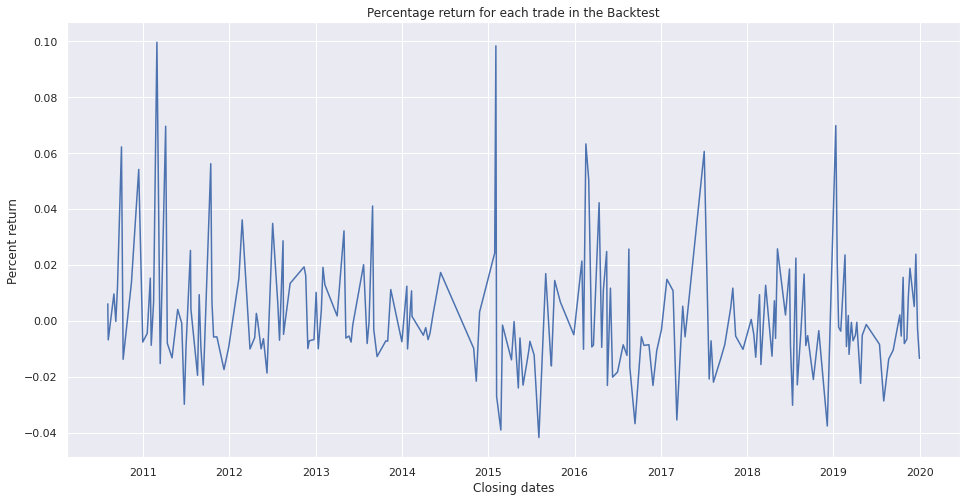

In [830]:
''' Creating the percentage return, and plotting it '''
trade_pairs_back['return_pct'] = trade_pairs_back['return'] / (-1 * trade_pairs_back['buy_price'])

fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharex=True)
ax1.set_title('Percentage return for each trade in the Backtest')
ax1.set_ylabel('Percent return')
ax1.set_xlabel('Closing dates')
sns.lineplot(data=trade_pairs_back , y='return_pct', x='sell_dates', ax=ax1, palette='Paired');

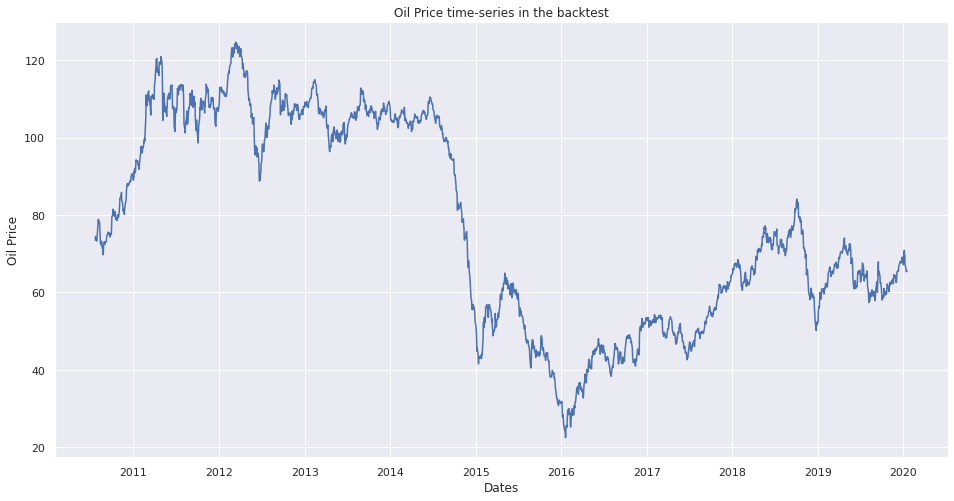

In [831]:
fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharex=True)
ax1.set_title('Oil Price time-series in the backtest')
ax1.set_ylabel('Oil Price')
ax1.set_xlabel('Dates')
sns.lineplot(data=strategy_back , y='oil_price', x=strategy_back.index, ax=ax1, palette='Paired');

In [836]:
pos_btrades = trade_pairs_back[trade_pairs_back['return_pct'] > 0].shape[0]
neg_btrades = trade_pairs_back[trade_pairs_back['return_pct'] < 0].shape[0]

print(f'The number of trades with positive return is {pos_btrades} and negative is {neg_btrades}')

The number of trades with positive return is 79 and negative is 126


In [837]:
time_frame_b = trade_pairs_back['sell_dates'] - trade_pairs_back['buy_dates']
print(f'The sum of days in a position is {time_frame_b.sum()}')
time_frame_b.describe()

The sum of days in a position is 577 days 00:00:00


count                          205
mean     2 days 19:33:04.390243902
std      2 days 13:23:40.293075589
min                1 days 00:00:00
25%                1 days 00:00:00
50%                2 days 00:00:00
75%                4 days 00:00:00
max               16 days 00:00:00
dtype: object

In [839]:
''' Calculating total percent return '''
total_pct_return_b = 1

for trade in trade_pairs_back['return_pct']:
    if trade >= 0:
        total_pct_return_b = total_pct_return_b * (1 + trade) #capitalize
    else:
        total_pct_return_b = total_pct_return_b / (1 + (-1* trade)) #discount

total_pct_return_b = total_pct_return_b-1
print(f'The total percentage return is {total_pct_return_b}')
print(f'Monthly rate of return is {((total_pct_return_b+1)**(1/len(time_frame_b)))**30-1}')

The total percentage return is 0.2228661436228252
Monthly rate of return is 0.029881268372468295


### Backtesting Results

In the **backtest** the strategy yielded *22.2% over 6.5 years*, considering in the end only the 577 days in a position, the effective montly rate of return is *2.98%*, a decent return, specially for a commodity which started with a price of 80, went all the way to 120, dropped to 20 and at the end of the backtest is around 65. Meaning even in a difficult market it thrives.

In [842]:
import pickle
pickle.dump(results,open("var-results.pkl", "wb"))